In [1]:
%load_ext tensorboard
import tensorflow as tf
import datetime
import pandas as pd
import string
import re
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
import trax
import os
import random as rnd
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import fastmath
import matplotlib as plt

In [2]:
rm -rf ./logs/ #clearing the logs for practice purposes

In [3]:
#using pandas to read in and displying the first 10 rows of the data
df1=pd.read_csv("Benchmark.csv",encoding='unicode_escape')
df1.head(10)

,ï»¿chatid,user,chatorder,text,ANGRY,HAPPY
0,1,Robert,1,"Hello, is this apple product support?",0.0,0.3
1,1,Bot,2,"Yes, it is. How may I help you?",0.0,0.7
2,1,Robert,3,I have a problem with one of the products that...,0.7,0.0
3,1,Bot,4,I am sorry for that. Can you please tell which...,0.0,0.0
4,1,Robert,5,"It is an iphone 10, it has been a week about n...",1.0,0.0
5,1,Bot,6,I understand the situation and I am glad to as...,0.0,2.0
6,1,Robert,7,My order id is 54569723 and I would like to ha...,0.3,0.0
7,1,Bot,8,"A replacement request has been created, please...",0.0,0.7
8,1,Robert,9,"Thank you for you help, have a good day",0.0,4.3
9,1,Bot,10,"You're welcome, have a great day!",0.0,4.7


In [4]:
positive_text=df1.text[df1.HAPPY>0] #Extracting the positive text where HAPPY label is >0
negative_text=df1.text[df1.ANGRY>0] #Extracting the negtive text where ANGRY label is >0
positive_labels=df1.HAPPY[df1.HAPPY>0] #Extracting the Positive labels where HAPPY >0
negative_labels=df1.ANGRY[df1.ANGRY>0] #Extracting negative labels where ANGRY >0
doc=df1.text  #made a copy of the data for further processing 
print(len(positive_text))
print(len(negative_text))
print(len(positive_labels))
print(len(negative_labels))
print(np.shape(negative_labels))


80
73
80
73
(73,)


In [5]:
#Spliting the dat into 80% training 20% testing/vlidating note:given the smll dataset, we can change these ratios to improve the model
val_pos = positive_text[64:].values.tolist()
train_pos = positive_text[:64].values.tolist()
val_neg = negative_text[58:].values.tolist()
train_neg = negative_text[:58].values.tolist()
val_lab_pos=positive_labels[64:].values.tolist()
train_lab_pos=positive_labels[:64].values.tolist()
val_lab_neg=negative_labels[58:].values.tolist()
train_lab_neg=negative_labels[:58].values.tolist()

#concatented pos and neg text into train_x and val_x vriables
train_x = train_pos + train_neg
val_x = val_pos + val_neg





In [6]:
#concatented pos and neg labels into train_y and val_y vriables
train_y = np.array(train_lab_pos+train_lab_neg)
train_y = train_y/5
print(train_y) #prints values stored in this variable
print(np.shape(train_y)) #prints the shape of this variable
# Set the labels for the validation set (1 for positive, 0 for negative)
val_y  = np.array(val_lab_pos+val_lab_neg)
print(np.shape(val_y))


[0.06       0.14       0.4        0.14       0.86       0.93999994
 0.6        0.06       0.6        0.14       0.14       0.06
 0.06       0.06       0.6        0.65999997 0.2        0.14
 0.2        0.06       0.14       0.06       0.2        0.14
 0.06       0.45999998 0.2        0.86       0.65999997 0.6
 0.2        0.14       0.06       0.2        0.6        0.06
 0.86       0.93999994 0.4        0.6        0.06       0.14
 0.14       0.06       0.06       0.06       0.34       0.06
 0.14       0.14       0.06       0.65999997 0.93999994 0.93999994
 0.26       0.06       0.14       0.6        0.26       0.6
 0.26       0.2        0.86       0.6        0.14       0.2
 0.06       0.06       0.6        0.06       0.93999994 1.
 0.06       0.14       0.86       0.93999994 0.06       0.14
 0.14       0.06       0.8        1.         0.06       0.14
 0.06       0.06       0.54       0.65999997 0.06       0.74
 0.26       0.2        0.14       0.06       0.54       0.34
 0.34       0.74 

In [7]:
def process_text(sent):
    """Process sent function.
    Input:
        sentence: a string containing a sentence
    Output:
        sent_clean: a list of words containing the processed sentence

    """
    #lemmatizer = WordNetLemmatizer()
    stopwords_english = stopwords.words('english')
    sent = re.sub('[^a-zA-Z]', ' ', sent)
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    sent = re.sub('\s+', ' ', sent).strip()
    #print(word_tokenize(text)) #uncomment if you'll like to see the tokens
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    tokenize=tokenizer.tokenize(sent)
    tokenize=[a.lower() for a in tokenize]
    sent_clean = []
    for d in tokenize:
        if (d not in stopwords_english and  # remove stopwords
                d not in string.punctuation):# remove punctuation
            #lem_sent=lemmatizer.lemmatize(d) #uncomment if you'll like to use the lemming
            sent_clean.append(d)
    return sent_clean

In [8]:
# Build the vocabulary
# Unit Test Note - There is no test set here only train/val

# Include special tokens 
# started with pad, end of line and unk tokens
Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2} 

# Note that we build vocab using training data
for sent in train_x: 
    process_sent = process_text(sent)
    print(process_sent)
    for word in process_sent:
        if word not in Vocab: 
            Vocab[word] = len(Vocab)
   
print("Total words in vocab are",len(Vocab))
display(Vocab)

['hello', 'apple', 'product', 'support']
['yes', 'may', 'help']
['understand', 'situation', 'glad', 'assist', 'please', 'share', 'order', 'id', 'let', 'know', 'would', 'like', 'return', 'replacement']
['replacement', 'request', 'created', 'please', 'carry', 'device', 'nearest', 'store', 'representatives', 'verify', 'replace', 'product']
['thank', 'help', 'good', 'day']
['welcome', 'great', 'day']
['good', 'day', 'today', 'bank', 'wealth', 'name', 'heather']
['would', 'like', 'know', 'remaining', 'money', 'account']
['glad', 'help', 'may', 'please', 'get', 'bank', 'account', 'number', 'name', 'account']
['sure', 'tracy', 'q', 'randall', 'account', 'number']
['thank', 'let', 'check', 'ok', 'please', 'verify', 'last', 'four', 'numbers', 'social', 'security', 'id']
['still', 'thousand', 'cents', 'anything', 'else', 'could', 'assist']
['yes', 'transfer', 'bank', 'account', 'lloyds', 'london', 'long', 'take']
['transaction', 'phone', 'online', 'team', 'still', 'contact', 'verification', 'pri

{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'hello': 3,
 'apple': 4,
 'product': 5,
 'support': 6,
 'yes': 7,
 'may': 8,
 'help': 9,
 'understand': 10,
 'situation': 11,
 'glad': 12,
 'assist': 13,
 'please': 14,
 'share': 15,
 'order': 16,
 'id': 17,
 'let': 18,
 'know': 19,
 'would': 20,
 'like': 21,
 'return': 22,
 'replacement': 23,
 'request': 24,
 'created': 25,
 'carry': 26,
 'device': 27,
 'nearest': 28,
 'store': 29,
 'representatives': 30,
 'verify': 31,
 'replace': 32,
 'thank': 33,
 'good': 34,
 'day': 35,
 'welcome': 36,
 'great': 37,
 'today': 38,
 'bank': 39,
 'wealth': 40,
 'name': 41,
 'heather': 42,
 'remaining': 43,
 'money': 44,
 'account': 45,
 'get': 46,
 'number': 47,
 'sure': 48,
 'tracy': 49,
 'q': 50,
 'randall': 51,
 'check': 52,
 'ok': 53,
 'last': 54,
 'four': 55,
 'numbers': 56,
 'social': 57,
 'security': 58,
 'still': 59,
 'thousand': 60,
 'cents': 61,
 'anything': 62,
 'else': 63,
 'could': 64,
 'transfer': 65,
 'lloyds': 66,
 'london': 67,
 'long': 

In [9]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: sent_to_tensor
def sent_to_tensor(sent, vocab_dict, unk_token='__UNK__', verbose=False):
    '''
    Input: 
        sent - A string containing a sentence
        vocab_dict - The words dictionary
        unk_token - The special string for unknown tokens
        verbose - Print info durign runtime
    Output:
        tensor_l - A python list with tensors
        
    '''  
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # Process the sentence into a list of words
    # where only important words are kept (stop words removed)
    word_l = process_text(sent)
    
    if verbose:
        print("List of words from the processed sentence:")
        print(word_l)
        
    # Initialize the list that will contain the unique integer IDs of each word
    tensor_l = []
    
    # Get the unique integer ID of the __UNK__ token
    unk_ID = Vocab.get('__UNK__')
    
    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")
        
    # for each word in the list:
    for word in word_l:
        
        # Get the unique integer ID.
        # If the word doesn't exist in the vocab dictionary,
        # use the unique ID for __UNK__ instead.
        word_ID = vocab_dict.get(word,unk_ID)
    ### END CODE HERE ###
        # Append the unique integer ID to the tensor list.
        tensor_l.append(word_ID)
    
    
    return tensor_l

In [10]:
print("Actual sentence is\n", val_pos[1])
print("\nTensor of sentence:\n", sent_to_tensor(val_pos[1], vocab_dict=Vocab))

Actual sentence is
 Yes I can help you. Could you please share me your order id 

Tensor of sentence:
 [7, 9, 64, 14, 15, 16, 17]


In [11]:
# test sent_to_tensor
#this test matches the text for val_pos[1] to its tensor given hard coded expected values and repeats the process for the 3 tests
def test_sent_to_tensor():
    test_cases = [
        
        {
            "name":"simple_test_check",
            "input": [val_pos[1], Vocab],
            "expected":[7, 9, 64, 14, 15, 16, 17],
            "error":"The function gives bad output for val_pos[1]. Test failed"
        },
        {
            "name":"datatype_check",
            "input":[val_pos[1], Vocab],
            "expected":type([]),
            "error":"Datatype mismatch. Need only list not np.array"
        },
        {
            "name":"without_unk_check",
            "input":[val_pos[1], Vocab],
            "expected":6,
            "error":"Unk word check not done- Please check if you included mapping for unknown word"
        }
    ]
    count = 0
    for test_case in test_cases:
        
        try:
            if test_case['name'] == "simple_test_check":
                assert test_case["expected"] == sent_to_tensor(*test_case['input'])
                count += 1
            if test_case['name'] == "datatype_check":
                assert isinstance(sent_to_tensor(*test_case['input']), test_case["expected"])
                count += 1
            if test_case['name'] == "without_unk_check":
                assert None not in sent_to_tensor(*test_case['input'])
                count += 1
                
            
            
        except:
            print(test_case['error'])
    if count == 3:
        print("\033[92m All tests passed")
    else:
        print(count," Tests passed out of 3")
test_sent_to_tensor()  

 All tests passed


In [12]:
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    '''
    Input: 
        data_pos - Set of posstive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - An array specifying the importance of each example
        
    '''     
### START GIVEN CODE ###
    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples
    assert batch_size % 2 == 0
    
    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2
    
    
    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
   
    
    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))
    
    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)
        
    stop = False
    
    # Loop indefinitely
    while not stop:  
        
        # create a batch with positive and negative examples
        batch = []
        
        # First part: Pack n_to_take positive examples
        
        # Start from pos_index and increment i up to n_to_take
        for i in range(n_to_take):
                    
            # If the positive index goes past the positive dataset lenght,
            if pos_index >= len_data_pos: 
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                
                # If user wants to keep re-using the data, reset the index
                pos_index = 0
                
                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)
                    
            # get the sentence as pos_index
            sent = data_pos[pos_index_lines[pos_index]]
           
            # convert the sentence into tensors of integers representing the processed words
            tensor = sent_to_tensor(sent, vocab_dict) #uses the function sent_to_tensor creted above
           
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment pos_index by one
            pos_index = pos_index + 1

### END GIVEN CODE ###
            
### START CODE HERE (Replace instances of 'None' with your code) ###

        # Second part: Pack n_to_take negative examples
    
        # Using the same batch list, start from neg_index and increment i up to n_to_take
        for i in range(n_to_take):
            
            # If the negative index goes past the negative dataset length,
            if neg_index >=len_data_neg:
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                    
                # If user wants to keep re-using the data, reset the index
                neg_index = 0
                
                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)
            # get the sntence as neg_index
            sent = data_neg[neg_index_lines[neg_index]]
            
            # convert the sentence into tensors of integers representing the processed words
            tensor = sent_to_tensor(sent,vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment neg_index by one
            neg_index = neg_index+1
            
### END CODE HERE ###        

### START GIVEN CODE ###
        if stop:
            break;

        # Update the start index for positive data 
        # so that it's n_to_take positions after the current pos_index
        pos_index += n_to_take
        
        # Update the start index for negative data 
        # so that it's n_to_take positions after the current neg_index
        neg_index += n_to_take
        
        # Get the max sentence length (the length of the longest sentence) 
        # (you will pad all shorter sentences to have this length)
        max_len = max([len(t) for t in batch]) 
        
        
        # Initialize the input_l, which will d 
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter sentences with zeros
        for tensor in batch:
### END GIVEN CODE ###

### START CODE HERE (Replace instances of 'None' with your code) ###
            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len - len(tensor)
            
            # Generate a list of zeros, with length n_pad
            pad_l = [0] * n_pad
            
            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor + pad_l 
            
            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.array(tensor_pad_l)
        
        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos =  [1]*n_to_take
        
        # Generate the list of targets for the negative examples (a list of zeros)
        # The length is the number of negative examples in the batch
        target_neg = [0]*n_to_take
        
        # Concatenate the positve and negative targets
        target_l = target_pos+target_neg
        
        # Convert the target list into a numpy array
        targets = np.array(target_l)
        
        # Example weights: Treat all examples equally importantly.It should return an np.array. Hint: Use np.ones_like()
        example_weights = np.ones_like(targets)
        

### END CODE HERE ###

### GIVEN CODE ###
        # note we use yield and not return
        yield inputs, targets, example_weights
        

In [13]:
# Set the random number generator for the shuffle procedure
rnd.seed(30) 

# Create the training data generator
def train_generator(batch_size, shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, True, Vocab, shuffle)

# Create the validation data generator
def val_generator(batch_size, shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, True, Vocab, shuffle)

# Create the validation data generator
def test_generator(batch_size, shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, False, Vocab, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[ 84  85  86  87  88   9  42   0   0   0   0   0   0   0   0]
 [174 175 176 177 178 179 180 181 182 183 184 185  59  84 172]
 [404   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [14]:
# Test the train_generator

# Create a data generator for training data,
# which produces batches of size 4 (for tensors and their respective targets)
tmp_data_gen = train_generator(batch_size = 4)

# Call the data generator to get one batch and its targets
tmp_inputs, tmp_targets, tmp_example_weights = next(tmp_data_gen)

print(f"The inputs shape is {tmp_inputs.shape}")
print(f"The targets shape is {tmp_targets.shape}")
print(f"The example weights shape is {tmp_example_weights.shape}")

for i,t in enumerate(tmp_inputs):
    print(f"input tensor: {t}; target {tmp_targets[i]}; example weights {tmp_example_weights[i]}")

The inputs shape is (4, 5)
The targets shape is (4,)
The example weights shape is (4,)
input tensor: [3 4 5 6 0]; target 1; example weights 1
input tensor: [7 8 9 0 0]; target 1; example weights 1
input tensor: [225  99 232 233  29]; target 0; example weights 1
input tensor: [234 235  71 236 237]; target 0; example weights 1


In [15]:
#helps with the forward propagaation of data
class Layer(object):
    """Base class for layers."""
    def __init__(self):
        self.weights = None

    def forward(self, x):
        raise NotImplementedError
  
    def init_weights_and_state(self, input_signature, random_key):
        pass

    def init(self, input_signature, random_key):
        self.init_weights_and_state(input_signature, random_key)
        return self.weights
    
    def __call__(self, x):
        return self.forward(x)

In [16]:
#creating and defining the Relu Layer by passing down the computation activation
class Relu(Layer):
    """Relu activation function implementation"""
    def forward(self, x):
        '''
        Input: 
            - x (a numpy array): the input
        Output:
            - activation (numpy array): all positive or 0 version of x
        '''
        ### START CODE HERE ###
        
        activation = np.maximum(x,0)

        ### END CODE HERE ###
        
        return activation

In [17]:
# use the fastmath module within trax
from trax import fastmath

# use the numpy module from trax
np = fastmath.numpy

# use the fastmath.random module from trax
random = fastmath.random

In [18]:
#defining and creating the Dense Layer 
class Dense(Layer):
    """
    A dense (fully-connected) layer.
    """

    # __init__ is implemented for you
    def __init__(self, n_units, init_stdev=0.1):
        
        # Set the number of units in this layer
        self._n_units = n_units
        self._init_stdev = init_stdev

    # Please implement 'forward()'
    def forward(self, x):

### START CODE HERE (Replace instances of 'None' with your code) ###

        # Matrix multiply x and the weight matrix
        dense = np.dot(x,self.weights) 
        
### END CODE HERE ###
        return dense

    # init_weights
    def init_weights_and_state(self, input_signature, random_key):
        
### START CODE HERE (Replace instances of 'None' with your code) ###
        # The input_signature has a .shape attribute that gives the shape as a tuple
        input_shape = (input_signature.shape[-1], self._n_units)

        # Generate the weight matrix from a normal distribution, 
        # and standard deviation of 'stdev'        
        w = trax.fastmath.random.normal(key=random_key, shape=input_shape) * self._init_stdev
        
### END CODE HERE ###     
        self.weights = w
        return self.weights

In [19]:
# Testing your Dense layer 
dense_layer = Dense(n_units=10)  #sets  number of units in dense layer (n_units=10)
random_key = random.get_prng(seed=0)  # sets random seed
z = np.array([[2.0, 7.0, 25.0]]) # input array 

dense_layer.init(z, random_key)
print("Weights are\n ",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is ", dense_layer(z)) # Returns multiplied values of units and weights

Weights are
  [[-0.02837108  0.09368162 -0.10050076  0.14165013  0.10543301  0.09108126
  -0.04265672  0.0986188  -0.05575325  0.00153249]
 [-0.20785688  0.0554837   0.09142365  0.05744595  0.07227863  0.01210617
  -0.03237354  0.16234995  0.02450038 -0.13809784]
 [-0.06111237  0.01403724  0.08410042 -0.1094358  -0.10775021 -0.11396459
  -0.05933381 -0.01557652 -0.03832145 -0.11144515]]
Foward function output is  [[-3.0395496   0.9266802   2.5414743  -2.050473   -1.9769388  -2.582209
  -1.7952735   0.94427425 -0.8980402  -3.7497487 ]]


In [20]:
# GRADED FUNCTION: classifier
def classifier(vocab_size=len(Vocab), embedding_dim=256, output_dim=2, mode='train'):
#note that we are using the trax framework so whenever you se tl. that's us implementing trax layers with required prameters
#this process cn be found in trax documentation 
### START CODE HERE (Replace instances of 'None' with your code) ###
    # create embedding layer
    embed_layer = tl.Embedding(
        vocab_size=vocab_size, # Size of the vocabulary
        d_feature=embedding_dim)  # Embedding dimension
    
    # Create a mean layer, to create an "average" word embedding
    mean_layer = tl.Mean(axis=1)
    
    # Create a dense layer, one unit for each output
    dense_output_layer = tl.Dense(n_units = output_dim)

    # Create the Relu layer
    relu_layer= tl.Relu()
    # Create the log softmax layer (no parameters needed)
    softmax_layer = tl.Softmax()
    
    # Use tl.Serial to combine all layers
    # and create the classifier
    # of type trax.layers.combinators.Serial
    model = tl.Serial(
      embed_layer, # embedding layer
      mean_layer, # mean layer
      dense_output_layer, # dense output layer  
      softmax_layer #  softmax layer
    )
### END CODE HERE ###     
    
    # return the model of type
    return model

In [21]:
tmp_model = classifier()

In [22]:
print(type(tmp_model))
display(tmp_model)
#displaying the model

<class 'trax.layers.combinators.Serial'>


Serial[
  Embedding_407_256
  Mean
  Dense_2
  Softmax
]

In [23]:
from trax.supervised import training
#using trax to create the traaining loop, found in trax documentation
batch_size = 16
rnd.seed(271)

train_task = training.TrainTask(
    labeled_data=train_generator(batch_size=batch_size, shuffle=True),
    loss_layer=tl.WeightedCategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=20,
)

eval_task = training.EvalTask(
    labeled_data=val_generator(batch_size=batch_size, shuffle=True),
    metrics=[tl.WeightedCategoryCrossEntropy(), tl.WeightedCategoryAccuracy()],
)

model = classifier()

In [24]:
output_dir = '~/model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

/Users/lexroverts/model/


In [25]:
# GRADED FUNCTION: train_model
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''
### START CODE HERE (Replace instances of 'None' with your code) ###
    training_loop = training.Loop(
                                classifier, # The learning model
                                train_task, # The training task
                                eval_tasks = [eval_task], # The evaluation task
                                output_dir = output_dir) # The output directory

    training_loop.run(n_steps = n_steps)
### END CODE HERE ###

    # Return the training_loop, since it has the model.
    return training_loop

In [26]:
training_loop = train_model(model, train_task, eval_task,100, output_dir_expand)


Step    320: Ran 20 train steps in 6.69 secs
Step    320: train WeightedCategoryCrossEntropy |  0.33788642
Step    320: eval  WeightedCategoryCrossEntropy |  0.67394537
Step    320: eval      WeightedCategoryAccuracy |  0.62500000

Step    340: Ran 20 train steps in 2.84 secs
Step    340: train WeightedCategoryCrossEntropy |  0.33307168
Step    340: eval  WeightedCategoryCrossEntropy |  0.80600685
Step    340: eval      WeightedCategoryAccuracy |  0.50000000

Step    360: Ran 20 train steps in 0.22 secs
Step    360: train WeightedCategoryCrossEntropy |  0.33478776
Step    360: eval  WeightedCategoryCrossEntropy |  0.59931570
Step    360: eval      WeightedCategoryAccuracy |  0.75000000

Step    380: Ran 20 train steps in 0.22 secs
Step    380: train WeightedCategoryCrossEntropy |  0.32566684
Step    380: eval  WeightedCategoryCrossEntropy |  0.64022928
Step    380: eval      WeightedCategoryAccuracy |  0.68750000

Step    400: Ran 20 train steps in 0.22 secs
Step    400: train Weighte

In [27]:
tensorboard --logdir '~/model/'
#Using trax has made it  bit difficult to obtin the history of the model, however using tensorboard can help us visualize our training metrics

In [28]:
# GRADED FUNCTION: compute_accuracy
def compute_accuracy(preds, y, y_weights):
    """
    Input: 
        preds: a tensor of shape (dim_batch, output_dim) 
        y: a tensor of shape (dim_batch,) with the true labels
        y_weights: a n.ndarray with the a weight for each example
    Output: 
        accuracy: a float between 0-1 
        weighted_num_correct (np.float32): Sum of the weighted correct predictions
        sum_weights (np.float32): Sum of the weights
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # Create an array of booleans, 
    # True if the probability of positive sentiment is greater than
    # the probability of negative sentiment
    # else False
    is_pos =  preds[:,1] > preds[:,0]

    # convert the array of booleans into an array of np.int32
    is_pos_int = is_pos.astype(np.int32)
    
    # compare the array of predictions (as int32) with the target (labels) of type int32
    correct = np.equal(is_pos_int, y)

    # Count the sum of the weights.
    sum_weights = np.sum(y_weights)
    
    # convert the array of correct predictions (boolean) into an arrayof np.float32
    correct_float = correct.astype(np.float32)
    
    # Multiply each prediction with its corresponding weight.
    weighted_correct_float = correct_float*sum_weights

    # Sum up the weighted correct predictions (of type np.float32), to go in the
    # denominator.
    weighted_num_correct = np.sum(correct_float)
 
    # Divide the number of weighted correct predictions by the sum of the
    # weights.
    accuracy =   weighted_num_correct/sum_weights

    ### END CODE HERE ###
    return accuracy, weighted_num_correct, sum_weights

In [29]:
# test your function (64)
tmp_val_generator = val_generator(10)

# get one batch
tmp_batch = next(tmp_val_generator)

# Position 0 has the model inputs (sentence as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

# feed the sentence tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)

tmp_acc, tmp_num_correct, tmp_num_predictions = compute_accuracy(preds=tmp_pred, y=tmp_targets, y_weights=tmp_example_weights)

print(f"Model's prediction accuracy on a single training batch is: {100 * tmp_acc}%")
print(f"Weighted number of correct predictions {tmp_num_correct}; weighted number of total observations predicted {tmp_num_predictions}")

Model's prediction accuracy on a single training batch is: 90.0%
Weighted number of correct predictions 9.0; weighted number of total observations predicted 10


In [30]:
tmp_train_generator=train_generator

In [31]:

for sent in train_x:
    inputs = np.array(sent_to_tensor(sent, vocab_dict=Vocab))
    #print(sent,inputs)
    inputs = inputs[None, :]
    #junk=np.where(inputs[0].size==(0))
    #inputs=np.delete(inputs,junk,0)
    #print(junk)
    try:
        predictions=model(inputs)
        ##print(f'example input_str: {sent}')
    #print(f'Model returned sentiment probabilities: {predictions.argmax(axis=1)}')
        ##print(f'Model returned sentiment probabilities: {predictions}')
    except:
        pass
        

In [32]:
y_preds=[] #storage for prediction
texts=[] #storage for text
for sent in doc: #iterating through each sentence in the doc
    inputs = np.array(sent_to_tensor(sent, vocab_dict=Vocab)) converting tensors to arrays
    #print(sent,inputs) # uncomment to observe the work
    inputs = inputs[None, :]
    #junk=np.where(inputs[0].size==(0))
    #inputs=np.delete(inputs,junk,0)
    #print(junk)
    try:
        predictions=model(inputs) #feeding the inputs to the model
        y_preds.append(predictions) 
        texts.append(sent)
        print(f'example input_str: {sent}')
    #print(f'Model returned sentiment probabilities: {predictions.argmax(axis=1)}')
        print(f'Model returned sentiment probabilities: {predictions}')
    except:
        pass

example input_str: Hello, is this apple product support?
Model returned sentiment probabilities: [[7.252177e-35 1.000000e+00]]
example input_str: Yes, it is. How may I help you?
Model returned sentiment probabilities: [[0. 1.]]
example input_str: I have a problem with one of the products that I have purchased at your store
Model returned sentiment probabilities: [[1.000000e+00 2.242258e-38]]
example input_str: I am sorry for that. Can you please tell which product is it and what is the issue?
Model returned sentiment probabilities: [[7.19441e-12 1.00000e+00]]
example input_str: It is an iphone 10, it has been a week about now and the phone has started to overheat.
Model returned sentiment probabilities: [[1.0000000e+00 4.8554785e-32]]
example input_str: I understand the situation and I am glad to assist you with it, can you please share the order id and let me know if you would like to have a return or replacement for it.
Model returned sentiment probabilities: [[1.8241906e-09 1.000000

In [33]:
y_preds=np.array(y_preds) #converting data typr to array
#texs=np.array(texts)
y_preds=y_preds*5 
y_preds=y_preds.tolist()
#texts=texts.tolist()
df2=pd.DataFrame(texts,columns=['text']) #adding y_preds to the initial dataframe
df2['preds']=y_preds

In [34]:
display(df2)

,text,preds
0,"Hello, is this apple product support?","[[3.6260882907773006e-34, 5.0]]"
1,"Yes, it is. How may I help you?","[[0.0, 5.0]]"
2,I have a problem with one of the products that...,"[[5.0, 1.1211290150809562e-37]]"
3,I am sorry for that. Can you please tell which...,"[[3.597205172622964e-11, 5.0]]"
4,"It is an iphone 10, it has been a week about n...","[[5.0, 2.427739313897334e-31]]"
...,...,...
188,CONNECT ME TO SOMEONE ELSE NOW,"[[1.778057562296098e-11, 5.0]]"
189,I WILL NOT APOLOGIZE TO YOU.,"[[4.300931930541992, 0.6990683674812317]]"
190,ARE YOU TRANSFERRING ME OR NOT?,"[[4.300931930541992, 0.6990683674812317]]"
191,May I have your phone number please?,"[[0.0, 5.0]]"


In [35]:
merged_df = pd.merge(df1, df2,on=['text','text'], how="outer")
display(merged_df)
#merging this df2 with df1

,ï»¿chatid,user,chatorder,text,ANGRY,HAPPY,preds
0,1,Robert,1,"Hello, is this apple product support?",0.0,0.3,"[[3.6260882907773006e-34, 5.0]]"
1,1,Bot,2,"Yes, it is. How may I help you?",0.0,0.7,"[[0.0, 5.0]]"
2,1,Robert,3,I have a problem with one of the products that...,0.7,0.0,"[[5.0, 1.1211290150809562e-37]]"
3,1,Bot,4,I am sorry for that. Can you please tell which...,0.0,0.0,"[[3.597205172622964e-11, 5.0]]"
4,1,Robert,5,"It is an iphone 10, it has been a week about n...",1.0,0.0,"[[5.0, 2.427739313897334e-31]]"
...,...,...,...,...,...,...,...
194,12,Tony,58,CONNECT ME TO SOMEONE ELSE NOW,4.7,0.0,"[[1.778057562296098e-11, 5.0]]"
195,12,Tony,59,I WILL NOT APOLOGIZE TO YOU.,5.0,0.0,"[[4.300931930541992, 0.6990683674812317]]"
196,12,Tony,60,ARE YOU TRANSFERRING ME OR NOT?,3.7,0.0,"[[4.300931930541992, 0.6990683674812317]]"
197,12,Bot,61,May I have your phone number please?,0.0,0.3,"[[0.0, 5.0]]"


In [36]:
pd.set_option('display.max_rows', None)
merged_df["preds"]=merged_df["preds"].replace(np.nan,0) #replacing instnces of nan values with zeros
display(merged_df)

,ï»¿chatid,user,chatorder,text,ANGRY,HAPPY,preds
0,1,Robert,1,"Hello, is this apple product support?",0.0,0.3,"[[3.6260882907773006e-34, 5.0]]"
1,1,Bot,2,"Yes, it is. How may I help you?",0.0,0.7,"[[0.0, 5.0]]"
2,1,Robert,3,I have a problem with one of the products that...,0.7,0.0,"[[5.0, 1.1211290150809562e-37]]"
3,1,Bot,4,I am sorry for that. Can you please tell which...,0.0,0.0,"[[3.597205172622964e-11, 5.0]]"
4,1,Robert,5,"It is an iphone 10, it has been a week about n...",1.0,0.0,"[[5.0, 2.427739313897334e-31]]"
5,1,Bot,6,I understand the situation and I am glad to as...,0.0,2.0,"[[9.120952881858102e-09, 5.0]]"
6,1,Robert,7,My order id is 54569723 and I would like to ha...,0.3,0.0,"[[5.0, 1.0763349304714065e-13]]"
7,1,Bot,8,"A replacement request has been created, please...",0.0,0.7,"[[3.114244843575381e-18, 5.0]]"
8,1,Robert,9,"Thank you for you help, have a good day",0.0,4.3,"[[0.0, 5.0]]"
9,1,Bot,10,"You're welcome, have a great day!",0.0,4.7,"[[0.0, 5.0]]"


In [37]:
merged_df['preds']=merged_df["preds"].apply(lambda x: [[0.0, 0.0]] if x==0 else x) #transformiz zero values to array shape (2,1) 

In [38]:
display(merged_df)

,ï»¿chatid,user,chatorder,text,ANGRY,HAPPY,preds
0,1,Robert,1,"Hello, is this apple product support?",0.0,0.3,"[[3.6260882907773006e-34, 5.0]]"
1,1,Bot,2,"Yes, it is. How may I help you?",0.0,0.7,"[[0.0, 5.0]]"
2,1,Robert,3,I have a problem with one of the products that...,0.7,0.0,"[[5.0, 1.1211290150809562e-37]]"
3,1,Bot,4,I am sorry for that. Can you please tell which...,0.0,0.0,"[[3.597205172622964e-11, 5.0]]"
4,1,Robert,5,"It is an iphone 10, it has been a week about n...",1.0,0.0,"[[5.0, 2.427739313897334e-31]]"
5,1,Bot,6,I understand the situation and I am glad to as...,0.0,2.0,"[[9.120952881858102e-09, 5.0]]"
6,1,Robert,7,My order id is 54569723 and I would like to ha...,0.3,0.0,"[[5.0, 1.0763349304714065e-13]]"
7,1,Bot,8,"A replacement request has been created, please...",0.0,0.7,"[[3.114244843575381e-18, 5.0]]"
8,1,Robert,9,"Thank you for you help, have a good day",0.0,4.3,"[[0.0, 5.0]]"
9,1,Bot,10,"You're welcome, have a great day!",0.0,4.7,"[[0.0, 5.0]]"


In [39]:
merged_df[['angry']]=merged_df.preds.apply(lambda x: x[0][0] ) #breaking the preds array values and adding angry values column

In [40]:
display(merged_df)

,ï»¿chatid,user,chatorder,text,ANGRY,HAPPY,preds,angry
0,1,Robert,1,"Hello, is this apple product support?",0.0,0.3,"[[3.6260882907773006e-34, 5.0]]",3.626088e-34
1,1,Bot,2,"Yes, it is. How may I help you?",0.0,0.7,"[[0.0, 5.0]]",0.000000e+00
2,1,Robert,3,I have a problem with one of the products that...,0.7,0.0,"[[5.0, 1.1211290150809562e-37]]",5.000000e+00
3,1,Bot,4,I am sorry for that. Can you please tell which...,0.0,0.0,"[[3.597205172622964e-11, 5.0]]",3.597205e-11
4,1,Robert,5,"It is an iphone 10, it has been a week about n...",1.0,0.0,"[[5.0, 2.427739313897334e-31]]",5.000000e+00
5,1,Bot,6,I understand the situation and I am glad to as...,0.0,2.0,"[[9.120952881858102e-09, 5.0]]",9.120953e-09
6,1,Robert,7,My order id is 54569723 and I would like to ha...,0.3,0.0,"[[5.0, 1.0763349304714065e-13]]",5.000000e+00
7,1,Bot,8,"A replacement request has been created, please...",0.0,0.7,"[[3.114244843575381e-18, 5.0]]",3.114245e-18
8,1,Robert,9,"Thank you for you help, have a good day",0.0,4.3,"[[0.0, 5.0]]",0.000000e+00
9,1,Bot,10,"You're welcome, have a great day!",0.0,4.7,"[[0.0, 5.0]]",0.000000e+00


In [41]:
merged_df[['happy']]=merged_df.preds.apply(lambda x: x[0][1] ) # adding the happy values column

In [42]:
display(merged_df)

,ï»¿chatid,user,chatorder,text,ANGRY,HAPPY,preds,angry,happy
0,1,Robert,1,"Hello, is this apple product support?",0.0,0.3,"[[3.6260882907773006e-34, 5.0]]",3.626088e-34,5.000000e+00
1,1,Bot,2,"Yes, it is. How may I help you?",0.0,0.7,"[[0.0, 5.0]]",0.000000e+00,5.000000e+00
2,1,Robert,3,I have a problem with one of the products that...,0.7,0.0,"[[5.0, 1.1211290150809562e-37]]",5.000000e+00,1.121129e-37
3,1,Bot,4,I am sorry for that. Can you please tell which...,0.0,0.0,"[[3.597205172622964e-11, 5.0]]",3.597205e-11,5.000000e+00
4,1,Robert,5,"It is an iphone 10, it has been a week about n...",1.0,0.0,"[[5.0, 2.427739313897334e-31]]",5.000000e+00,2.427739e-31
5,1,Bot,6,I understand the situation and I am glad to as...,0.0,2.0,"[[9.120952881858102e-09, 5.0]]",9.120953e-09,5.000000e+00
6,1,Robert,7,My order id is 54569723 and I would like to ha...,0.3,0.0,"[[5.0, 1.0763349304714065e-13]]",5.000000e+00,1.076335e-13
7,1,Bot,8,"A replacement request has been created, please...",0.0,0.7,"[[3.114244843575381e-18, 5.0]]",3.114245e-18,5.000000e+00
8,1,Robert,9,"Thank you for you help, have a good day",0.0,4.3,"[[0.0, 5.0]]",0.000000e+00,5.000000e+00
9,1,Bot,10,"You're welcome, have a great day!",0.0,4.7,"[[0.0, 5.0]]",0.000000e+00,5.000000e+00


In [ ]:
#we will convert all columns of interest into intreger values in order to create a decision matrix 

In [43]:
merged_df['angry']=merged_df['angry'].astype(int)

In [44]:
merged_df['happy']=merged_df['happy'].astype(int)
merged_df['ANGRY1']=merged_df['ANGRY'].astype(int)
merged_df['HAPPY1']=merged_df['HAPPY'].astype(int)

In [45]:
display(merged_df)

,ï»¿chatid,user,chatorder,text,ANGRY,HAPPY,preds,angry,happy,ANGRY1,HAPPY1
0,1,Robert,1,"Hello, is this apple product support?",0.0,0.3,"[[3.6260882907773006e-34, 5.0]]",0,5,0,0
1,1,Bot,2,"Yes, it is. How may I help you?",0.0,0.7,"[[0.0, 5.0]]",0,5,0,0
2,1,Robert,3,I have a problem with one of the products that...,0.7,0.0,"[[5.0, 1.1211290150809562e-37]]",5,0,0,0
3,1,Bot,4,I am sorry for that. Can you please tell which...,0.0,0.0,"[[3.597205172622964e-11, 5.0]]",0,5,0,0
4,1,Robert,5,"It is an iphone 10, it has been a week about n...",1.0,0.0,"[[5.0, 2.427739313897334e-31]]",5,0,1,0
5,1,Bot,6,I understand the situation and I am glad to as...,0.0,2.0,"[[9.120952881858102e-09, 5.0]]",0,5,0,2
6,1,Robert,7,My order id is 54569723 and I would like to ha...,0.3,0.0,"[[5.0, 1.0763349304714065e-13]]",5,0,0,0
7,1,Bot,8,"A replacement request has been created, please...",0.0,0.7,"[[3.114244843575381e-18, 5.0]]",0,5,0,0
8,1,Robert,9,"Thank you for you help, have a good day",0.0,4.3,"[[0.0, 5.0]]",0,5,0,4
9,1,Bot,10,"You're welcome, have a great day!",0.0,4.7,"[[0.0, 5.0]]",0,5,0,4


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

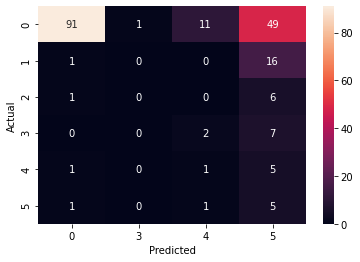

In [46]:
import seaborn as sn
import tkinter
import matplotlib.pyplot as plt
%matplotlib inline
confusion_matrix = pd.crosstab(merged_df['ANGRY1'], merged_df['angry'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

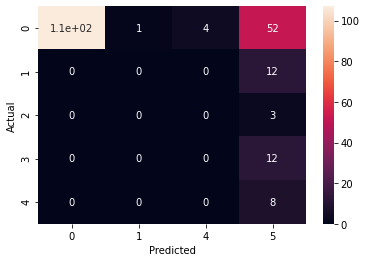

In [47]:
confusion_matrix2 = pd.crosstab(merged_df['HAPPY1'], merged_df['happy'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix2, annot=True)